In [1]:
pip install pandas

In [2]:
pip install sklearn

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


 Diabetes Prediction and Explanation Using Machine Learning and a Large Language Model

In [6]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

# Load the dataset
data = pd.read_csv('/content/diabetes.csv')

# Check the first few rows of the dataset
print(data.head())

# Split the dataset into features and labels
X = data.drop(columns='Outcome')  # Features
y = data['Outcome']                # Label (0 for non-diabetic, 1 for diabetic)

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Classifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_val)
print(classification_report(y_val, y_pred))

# Load a pre-trained LLM
model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
llm_model = AutoModelForCausalLM.from_pretrained(model_name)

# Function to generate detailed explanations
def generate_detailed_explanation(input_features, prediction):
    # Structure the input to be clearer for the model
    features_summary = (
        f"Pregnancies: {input_features['Pregnancies']}, "
        f"Glucose: {input_features['Glucose']}, "
        f"Blood Pressure: {input_features['BloodPressure']}, "
        f"Skin Thickness: {input_features['SkinThickness']}, "
        f"Insulin: {input_features['Insulin']}, "
        f"BMI: {input_features['BMI']}, "
        f"Diabetes Pedigree Function: {input_features['DiabetesPedigreeFunction']}, "
        f"Age: {input_features['Age']}"
    )

    # Create a detailed prompt for the LLM
    input_text = (
        f"Based on the following medical parameters:\n"
        f"{features_summary}\n"
        f"The prediction for diabetes is: {prediction}.\n"
        "Explain how these parameters might influence the risk of diabetes."
    )

    # Tokenize and generate predictions
    inputs = tokenizer.encode(input_text, return_tensors='pt')
    outputs = llm_model.generate(inputs, max_length=150)

    explanation = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return explanation

# Example usage: Generate explanation for the first instance in the validation set
example_features = X_val.iloc[0].to_dict()  # Get features for one instance
example_prediction = y_pred[0]                # Get prediction for that instance

explanation = generate_detailed_explanation(example_features, example_prediction)
print("Generated Explanation:")
print(explanation)


   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  
              precision    recall  f1-score   support

           0       0.79      0.78      0.78        99
           1       0.61      0.62      0.61        55

    accuracy                           0.72       154
   macro avg       0.70      0.70      0.70       154
weighted avg       0.72      0.

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Generated Explanation:
Based on the following medical parameters:
Pregnancies: 6.0, Glucose: 98.0, Blood Pressure: 58.0, Skin Thickness: 33.0, Insulin: 190.0, BMI: 34.0, Diabetes Pedigree Function: 0.43, Age: 43.0
The prediction for diabetes is: 0.
Explain how these parameters might influence the risk of diabetes.
The risk of diabetes is based on the following medical parameters:
Pregnancies: 6.0, Glucose: 98.0, Blood Pressure: 58.0, Skin Thickness: 33.0, Insulin: 190.0, BMI: 34.0, Diabetes Pedigree Function


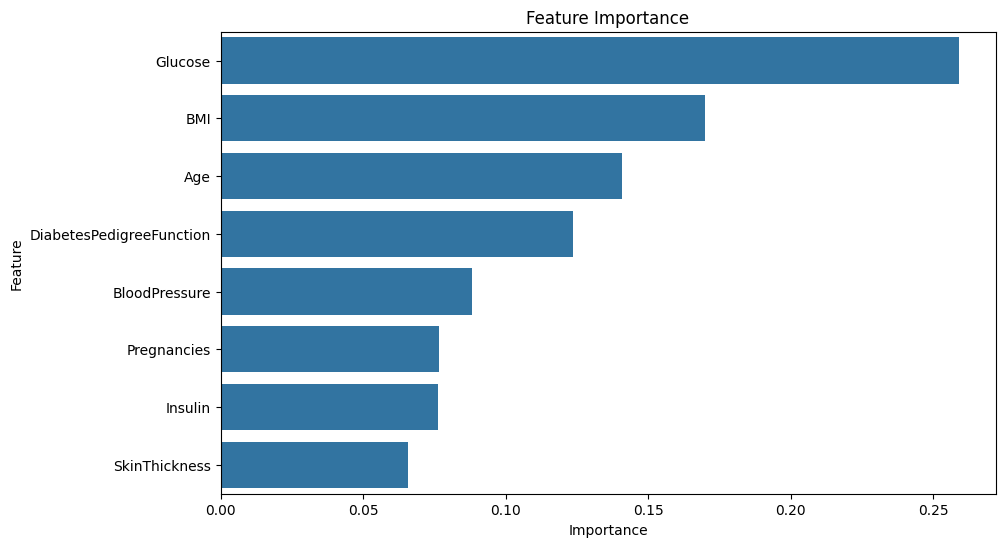

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Plot Feature Importance
def plot_feature_importance(model, features):
    importance = model.feature_importances_
    feature_names = features.columns
    feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
    feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance)
    plt.title('Feature Importance')
    plt.show()

plot_feature_importance(model, X_train)

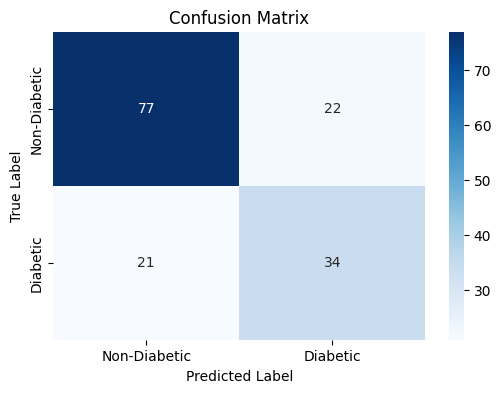

In [11]:
# Plot Confusion Matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Diabetic', 'Diabetic'], yticklabels=['Non-Diabetic', 'Diabetic'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# Call the functions to display the plots
plot_confusion_matrix(y_val, y_pred)
